# Análisis Exploratorio de Datos (EDA) – 30 Empresas Tecnológicas

Este notebook realiza un análisis inicial de los datos descargados de yfinance:
- Panel mensual de precios y retornos
- Estadísticas descriptivas
- Gráficos de tendencia y volatilidad

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuración de visualización
sns.set(style='whitegrid')
%matplotlib inline


In [2]:
# ---------------------------------
# RUTAS (robustas desde notebooks/)
# ---------------------------------

NOTEBOOK_DIR = os.getcwd()                 # .../AlphaTech-Analyzer/notebooks
PROJECT_ROOT = os.path.dirname(NOTEBOOK_DIR)

PROCESSED_DIR = os.path.join(PROJECT_ROOT, "data", "processed")

PANEL_FILE = os.path.join(PROCESSED_DIR, "tech30_panel_monthly_2018_2024.csv")
AGG_FILE   = os.path.join(PROCESSED_DIR, "tech30_aggregated_stats_2018_2024.csv")

# ---------------------------------
# VALIDACIÓN DE EXISTENCIA
# ---------------------------------

assert os.path.exists(PANEL_FILE), f"No se encontró: {PANEL_FILE}"
assert os.path.exists(AGG_FILE),   f"No se encontró: {AGG_FILE}"

# ---------------------------------
# CARGA DE DATOS
# ---------------------------------

panel_df = pd.read_csv(PANEL_FILE, parse_dates=["Date"])
agg_df   = pd.read_csv(AGG_FILE)

print("✅ Panel mensual:", panel_df.shape)
print("✅ Dataset agregado:", agg_df.shape)

✅ Panel mensual: (2403, 6)
✅ Dataset agregado: (30, 7)


In [3]:
# Revisar estadísticas básicas del panel
panel_df.describe()


,Date,AdjClose,Volume,Return
count,2403,2403.000000,2.403000e+03,2403.000000
mean,2021-08-30 03:08:09.887640320,2084.289002,8.409799e+08,0.015266
min,2018-02-28 00:00:00,3.309732,8.622200e+06,-0.676915
25%,2019-12-31 00:00:00,44.554747,8.869875e+07,-0.045282
50%,2021-08-31 00:00:00,113.000000,2.449590e+08,0.017335
75%,2023-04-30 00:00:00,222.747810,6.783272e+08,0.075117
max,2024-12-31 00:00:00,81511.546875,1.687099e+10,0.984401
std,NaN,10555.088858,1.905822e+09,0.108431


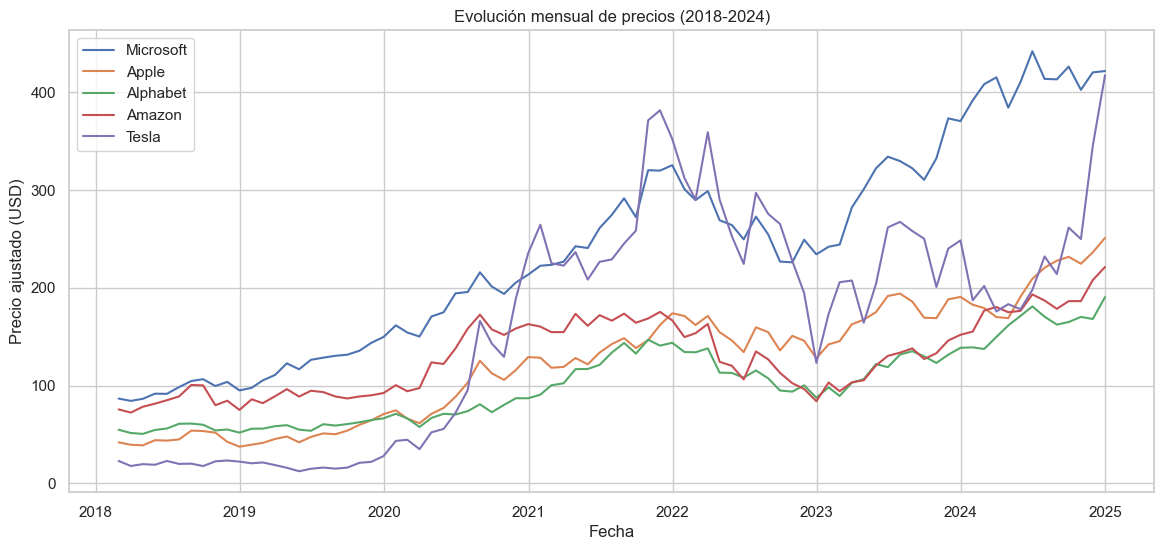

In [4]:
companies_to_plot = ['Microsoft', 'Apple', 'Alphabet', 'Amazon', 'Tesla']
plt.figure(figsize=(14,6))
for company in companies_to_plot:
    df_plot = panel_df[panel_df['Company']==company]
    plt.plot(df_plot['Date'], df_plot['AdjClose'], label=company)

plt.title('Evolución mensual de precios (2018-2024)')
plt.xlabel('Fecha')
plt.ylabel('Precio ajustado (USD)')
plt.legend()
plt.show()


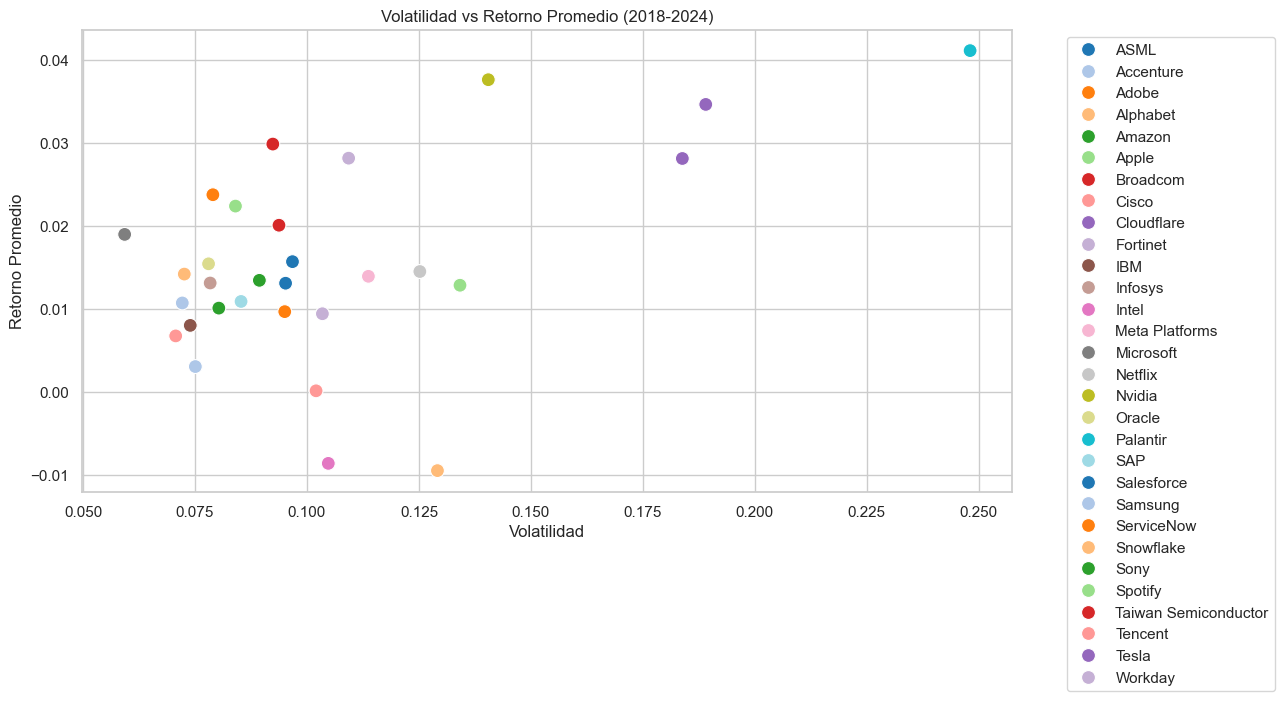

In [5]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=agg_df, x='Volatility', y='MeanReturn', hue='Company', palette='tab20', s=100)
plt.title('Volatilidad vs Retorno Promedio (2018-2024)')
plt.xlabel('Volatilidad')
plt.ylabel('Retorno Promedio')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()
